In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd

import dython

In [142]:
properties = pd.read_csv("../data/curated/properties_processed.csv", index_col=0)
income = pd.read_csv("../data/raw/external/vic_income.csv", index_col=0)
mapping = pd.read_csv("../data/raw/external/sa2_postcode_map.csv", index_col=0)

In [143]:
properties['Postcode'] = properties['Postcode'].astype(str)

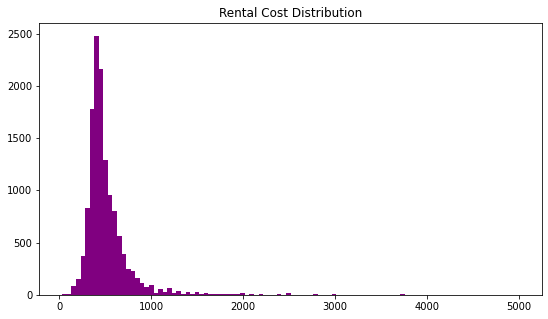

In [144]:
# Rental Cost Distribution
plt.figure(figsize = (9, 5))
plt.title('Rental Cost Distribution')
plt.hist(properties['Cost'], bins=100, color='purple')
plt.savefig('../plots/cost_distribution.jpg')
plt.show()

In [145]:
mapping['POSTCODE'] = mapping['POSTCODE'].astype(str)

In [146]:
properties = pd.merge(properties, mapping, left_on='Postcode', right_on='POSTCODE').drop('POSTCODE', axis=1)

In [147]:
properties['SA2_MAINCODE_2011'] = properties['SA2_MAINCODE_2011'].astype(str)
properties = properties.rename({'SA2_MAINCODE_2011':'SA2'})

## Income Data

In [148]:
income['SA2'] = income['SA2'].astype(str)
income.head()

,SA2,SA2_name,Earners,Median_age,Sum,Median
579,201011001,Alfredton,7989,42,508645842,53932
580,201011002,Ballarat,7595,47,591465895,53688
581,201011003,Ballarat - North,13598,43,820866354,50593
582,201011004,Ballarat - South,12722,40,646001740,45828
583,201011005,Buninyong,4249,46,268782250,52377


In [149]:
properties['SA2_MAINCODE_2011'] = properties['SA2_MAINCODE_2011'].astype(float).astype(int).astype(str)
properties = pd.merge(properties, income, left_on='SA2_MAINCODE_2011', right_on='SA2')
properties.head(1)

,Name,Cost,Coordinates,Bed,Bath,Parking,Property_Type,Agency,Postcode,SA2_MAINCODE_2011,SA2_NAME_2011,SA2,SA2_name,Earners,Median_age,Sum,Median
0,5408/500 Elizabeth Street Melbourne VIC 3000,440.0,"[-37.8072443, 144.9602814]",1,1,0,Apartment / Unit / Flat,BRADY residential,3000,206041122,Melbourne,206041122,Melbourne,27182,30,1426389488,30024


*Note:* We treat the ordinal features as continuous in order to keep ordering information.

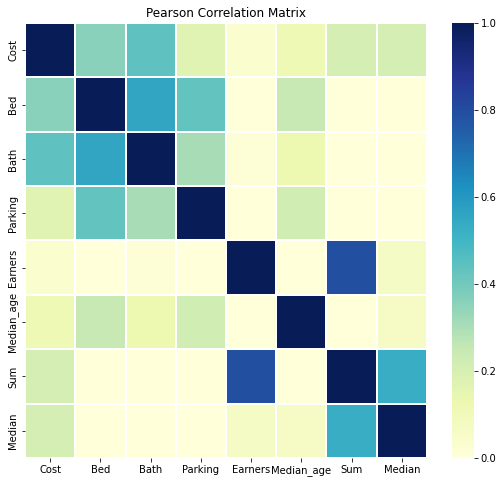

In [150]:
corrmat = properties.corr()
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1, vmin=0)

plt.title('Pearson Correlation Matrix')
plt.savefig('../plots/correlation.jpg')
plt.show()

TypeError: cannot handle data conversion of type: <class 'tuple'> to dataframe

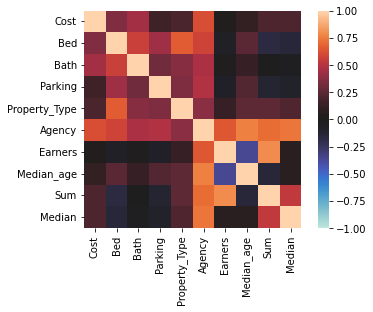

In [129]:
# get correlation of numeric attributes with cost
corr_data = properties[['Cost', 'Bed', 'Bath', 'Parking', 'Property_Type', 'Agency', 'Earners', 'Median_age', 'Sum', 'Median']]
corrmat = dython.nominal.associations(corr_data, annot=False, plot=False)
corr = corrmat['corr']
sorted = dython.nominal.cluster_correlations(corr)
dython.nominal.associations(sorted, annot=False, title='Correlation Matrix')

In [109]:
# test for relationship with categorical variables using one-way ANOVA
categoricals = ['Postcode', 'Property_Type', 'Agency']

for c in categoricals:
    model = ols('Cost ~ '+c, data = properties).fit() # Oridnary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

               df        sum_sq        mean_sq         F  PR(>F)
Postcode    374.0  2.019698e+08  540026.239923  9.126862     0.0
Residual  11465.0  6.783713e+08   59168.884891       NaN     NaN
                    df        sum_sq       mean_sq         F        PR(>F)
Property_Type      9.0  3.375730e+07  3.750811e+06  52.41311  5.539890e-94
Residual       11830.0  8.465838e+08  7.156245e+04       NaN           NaN
               df        sum_sq        mean_sq         F  PR(>F)
Agency     1335.0  3.347445e+08  250744.959848  4.827422     0.0
Residual  10504.0  5.455966e+08   51941.789567       NaN     NaN


All p values are less than 0.05 so all attributes are significant.

In [9]:
# read in shapefile and merge with SA2
sf = gpd.read_file('../data/raw/external/SA2_shapefile/SA2_2016_AUST.shp')
print(sf.head())
gdf = gpd.GeoDataFrame(
    pd.merge(income, sf, left_on='SA2', right_on='SA2_MAIN16', how='inner')
)
geoJSON = gdf[['SA2', 'geometry']].to_json()

  SA2_MAIN16 SA2_5DIG16         SA2_NAME16 SA3_CODE16  SA3_NAME16 SA4_CODE16  \
0  101021007      11007          Braidwood      10102  Queanbeyan        101   
1  101021008      11008            Karabar      10102  Queanbeyan        101   
2  101021009      11009         Queanbeyan      10102  Queanbeyan        101   
3  101021010      11010  Queanbeyan - East      10102  Queanbeyan        101   
4  101021011      11011  Queanbeyan Region      10102  Queanbeyan        101   

       SA4_NAME16 GCC_CODE16   GCC_NAME16 STE_CODE16       STE_NAME16  \
0  Capital Region      1RNSW  Rest of NSW          1  New South Wales   
1  Capital Region      1RNSW  Rest of NSW          1  New South Wales   
2  Capital Region      1RNSW  Rest of NSW          1  New South Wales   
3  Capital Region      1RNSW  Rest of NSW          1  New South Wales   
4  Capital Region      1RNSW  Rest of NSW          1  New South Wales   

   AREASQKM16                                           geometry  
0   3418.3525